Frame enumuration and submission to Hyp3 with Tropo, Iono, SET corrections.

In [1]:
from s1_frame_enumerator import (get_s1_stack, 
                                 filter_s1_stack_by_geometric_coverage_per_pass, 
                                 get_global_s1_frames, 
                                 get_overlapping_s1_frames, 
                                 enumerate_dates, 
                                 frames2gdf, 
                                 enumerate_gunw_time_series,
                                 gdf2frames)
from shapely.geometry import Point
import geopandas as gpd
from rasterio.crs import CRS
import matplotlib.pyplot as plt
import warnings
import json
import pandas as pd
import datetime
from tqdm import tqdm
from pathlib import Path
from itertools import starmap

# Paramaters

In [5]:
# AOI Name
AOI_NAME = 'mainland_us_coast'
STACK_DIR = None

# Hyp3 Paramaters
TEMPORAL_BASELINES_DAYS = [0, 180, 365]
NEIGHBORS = 2
IONOSPHERE = True
SET = True
WEATHER_MODEL = 'HRRR'

# Notebook Parameters
RECOMPUTE_STACKS = False

In [ ]:
stack_dir = STACK_DIR or Path('stacks') / AOI_NAME
stack_dir.mkdir(exist_ok=True, parents=True)

# Load AOI

<Axes: >

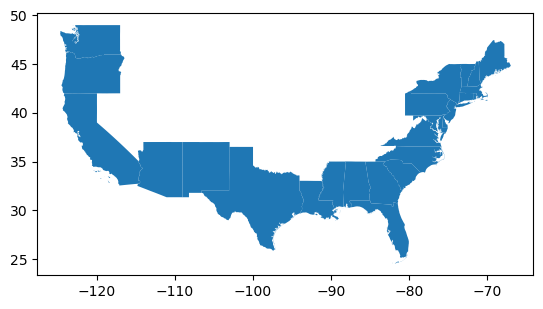

In [6]:
df_coastal_us = gpd.read_file(f'AOIs/{AOI_NAME}.geojson')
# This ensures we only get the mainland part
df_coastal_us.plot()

# Get Frames overlapping AOI

In [7]:
aoi_geo = df_coastal_us.geometry.unary_union
frames = get_overlapping_s1_frames(aoi_geo)
df_frames_all = frames2gdf(frames)
df_frames_all.head()

,frame_id,hemisphere,track_number_min,track_number_max,geometry
0,491,west,4,4,"POLYGON Z ((-77.55802 33.30969 0.00000, -77.71..."
1,492,west,4,4,"POLYGON Z ((-77.82534 34.47332 0.00000, -78.06..."
2,493,west,4,4,"POLYGON Z ((-78.09591 35.63539 0.00000, -78.33..."
3,494,west,4,4,"POLYGON Z ((-78.37797 36.81111 0.00000, -78.41..."
4,495,west,4,4,"POLYGON Z ((-78.65322 37.95742 0.00000, -78.73..."


Let's remove frames that have less than 25% overlap with our AOI. This ensures ISCE2 will have roughly enough area to process.

In [8]:
intersection_geo = df_frames_all.geometry.intersection(aoi_geo)
with warnings.catch_warnings():
    # yes, we are computing areas in lat/lon - that's ok at these latitudes
    warnings.simplefilter("ignore", category=UserWarning)
    percent_overlap = intersection_geo.area / df_frames_all.geometry.area
df_frames = df_frames_all[percent_overlap >= .2].reset_index(drop=True)
df_frames = df_frames.explode()
frames = gdf2frames(df_frames)

/var/folders/0p/d5x2m4tx5kg1246bplsvyfyh0000gq/T/ipykernel_11342/3762525945.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  df_frames = df_frames.explode()


(23.70927522851776, 50.61472809039068)

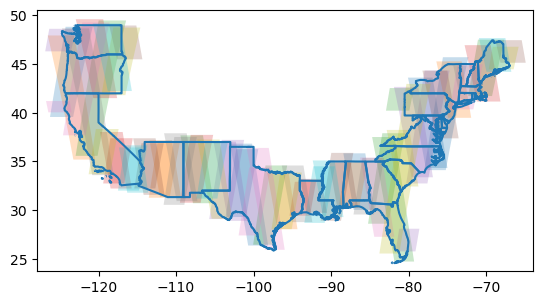

In [9]:
fig, ax = plt.subplots()
df_coastal_us.geometry.boundary.plot(ax=ax)
df_frames_by_track = df_frames.dissolve(by='track_number_min').reset_index(drop=False)
df_frames_by_track.plot(ax=ax, 
                        column='track_number_min',
                        categorical=True,
                        alpha=.25, 
                        #legend=True
                       )
xmin, ymin, xmax, ymax = df_frames_by_track.total_bounds
ax.set_xlim(xmin - 1, xmax + 1)
ax.set_ylim(ymin - 1, ymax + 1)

# Get Stack from Frame

If `RECOMPUTE_STACKS` is True, then will overwrite existing stack

In [11]:
all_tracks = df_frames.track_number_min.unique().tolist()

In [12]:
def id_formatter(row: pd.Series):
    """Returns 'track<track_number>' for first instance and then 'track<track_number>_k' for each subsequent k index"""
    if row['level_1']:
        return f"track{row['track_number_min']}_{row['level_1']}"
    else:
        return f"track{row['track_number_min']}"

df_track_aois = df_frames_by_track.explode().reset_index(drop=False)
df_track_aois['track_aoi_id'] = df_track_aois.apply(id_formatter, axis=1)
df_track_aois.head()

/var/folders/0p/d5x2m4tx5kg1246bplsvyfyh0000gq/T/ipykernel_11342/2628663778.py:8: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  df_track_aois = df_frames_by_track.explode().reset_index(drop=False)


,level_0,level_1,track_number_min,frame_id,hemisphere,track_number_max,geometry,track_aoi_id
0,0,0,4,492,west,4,"POLYGON Z ((-78.06076 35.48755 0.00000, -78.06...",track4
1,1,0,5,649,west,5,"POLYGON Z ((-100.95129 27.52268 0.00000, -100....",track5
2,2,0,11,1624,west,11,"POLYGON Z ((-77.75658 35.26745 0.00000, -77.75...",track11
3,3,0,12,1798,west,12,"POLYGON Z ((-103.39264 30.44650 0.00000, -103....",track12
4,4,0,13,1924,west,13,"POLYGON Z ((-126.01699 40.73057 0.00000, -126....",track13


In [13]:
track2frames = {row['track_aoi_id']: [f for f in frames 
                                      if row['track_number_min'] in f.track_numbers 
                                      if row['geometry'].intersects(f.frame_geometry)
                       ] 
                for _, row in df_track_aois.iterrows()}
track2frames['track4']

[S1Frame(frame_id=492, hemisphere='west', track_numbers=[4], frame_geometry=<POLYGON Z ((-77.825 34.473 0, -78.064 35.483 0, -78.06 35.484 0, -78.061 35...>, footprint_geometry=<POLYGON ((-77.744 34.126, -78.064 35.483, -78.06 35.484, -78.099 35.65, -77...>),
 S1Frame(frame_id=493, hemisphere='west', track_numbers=[4], frame_geometry=<POLYGON Z ((-78.096 35.635 0, -78.339 36.651 0, -75.472 36.651 0, -75.298 3...>, footprint_geometry=<POLYGON ((-75.238 35.485, -75.2 35.298, -76.07 35.183, -76.093 35.292, -76....>),
 S1Frame(frame_id=494, hemisphere='west', track_numbers=[4], frame_geometry=<POLYGON Z ((-78.378 36.811 0, -78.414 36.977 0, -78.618 37.813 0, -75.706 3...>, footprint_geometry=<POLYGON ((-77.308 36.32, -77.368 36.585, -78.291 36.45, -78.378 36.811, -78...>),
 S1Frame(frame_id=495, hemisphere='west', track_numbers=[4], frame_geometry=<POLYGON Z ((-78.653 37.957 0, -78.739 38.304 0, -78.734 38.305 0, -78.901 3...>, footprint_geometry=<POLYGON ((-77.57 37.482, -77.632 37.746, -

In [16]:
track_log = tqdm(total=0, position=0, bar_format='{desc}')

def get_s1_stack_and_serialize(track_aoi_id, frames, recompute_stack=RECOMPUTE_STACKS):
    if not frames:
        warnings.warn('No frames submitted')
        return
    track_stack_path = stack_dir / f'{track_aoi_id}-{AOI_NAME}.geojson'
    track_log.set_description_str(f'Current track: {track_stack_path}')
    
    if track_stack_path.exists() and (not recompute_stack):
        return track_stack_path
    df_stack = get_s1_stack(frames, minimum_coverage_ratio_per_frame=.2, minimum_coverage_ratio_per_pass=.8)
    if df_stack.empty:
        warnings.warn(f'Empty stack - still writing for records - check {track_aoi_id} on asf_search')
    df_stack.to_file(track_stack_path, driver='GeoJSON')
    return track_stack_path

In [ ]:
input_frame_data = list(track2frames.items())
stack_paths = list(starmap(get_s1_stack_and_serialize, tqdm(input_frame_data)))


Current track: stacks/mainland_us_coast/track4-mainland_us_coast.geojson                                                                                                                                                                                 | 0/65 [00:00<?, ?it/s]









/Users/cmarshak/bekaert-team/s1-frame-enumerator/s1_frame_enumerator/s1_stack.py:80: UserWarning: Frame 496 did not have enough coverage on 2016-09-24 (ratio of coverage was 0.18)
  warn(f'Frame {frame.frame_id} did not have enough coverage '

Current track: stacks/mainland_us_coast/track5-mainland_us_coast.geojson                                                                                                                                                                       | 1/65 [01:06<1:11:06, 66.67s/it]











Current track: stacks/mainland_us_coast/track11-mainland_us_coast.geojson                                                                                                                    





/Users/cmarshak/bekaert-team/s1-frame-enumerator/s1_frame_enumerator/s1_stack.py:137: UserWarning: Ensuring per pass coverage of 0.8 left no available images in the stack
  warn(f'Ensuring per pass coverage of {ratio} left no available images in the stack',
/Users/cmarshak/bekaert-team/s1-frame-enumerator/s1_frame_enumerator/s1_stack.py:146: UserWarning: Ensuring per frame coverage of 0.2 left no available images in the stack
  warn(f'Ensuring per frame coverage of {ratio} left no available images in the stack',
/var/folders/0p/d5x2m4tx5kg1246bplsvyfyh0000gq/T/ipykernel_11342/498282542.py:14: UserWarning: Empty stack - still writing for records - check track11 on asf_search
  warnings.warn(f'Empty stack - still writing for records - check {track_aoi_id} on asf_search')
/Users/cmarshak/mambaforge/envs/s1-frame-enumerator/lib/python3.11/site-packages/geopandas/io/file.py:545: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fai






Current track: stacks/mainland_us_coast/track27-mainland_us_coast.geojson                                                                                                                                                                        | 8/65 [06:59<41:49, 44.03s/it]







Current track: stacks/mainland_us_coast/track33-mainland_us_coast.geojson                                                                                                                                                                        | 9/65 [07:50<42:57, 46.02s/it]







Current track: stacks/mainland_us_coast/track34-mainland_us_coast.geojson                                                                                                                                                                       | 10/65 [08:45<44:56, 49.03s/it]





# Generate IFG Pairs

In [ ]:
submission_data_dir = Path('submission_data')
submission_data_dir.mkdir(exist_ok=True, parents=True)

In [ ]:
IFG_COLUMNS = ['reference', 'secondary', 'reference_date', 'secondary_date', 'frame_id', 'geometry']
def encode_dataframe_for_serialization(df_ifg: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    df_ifg['reference_date'] = df_ifg['reference_date'].dt.date.astype(str)
    df_ifg['secondary_date'] = df_ifg['secondary_date'].dt.date.astype(str)
    
    df_ifg['reference'] = df_ifg['reference'].map(lambda l: ' '.join(l))
    df_ifg['secondary'] = df_ifg['secondary'].map(lambda l: ' '.join(l))
    
    df_ifg.crs = CRS.from_epsg(4326)
    return df_ifg  


def enumerate_one_stack(stack_path: Path, 
                        temporal_baselines_days: list = None, 
                        neighbors=NEIGHBORS):
    temporal_baselines_days = temporal_baselines_days or TEMPORAL_BASELINES_DAYS
    df_stack = gpd.read_file(stack_path)
    
    stack_path_stem = stack_path.stem
    track_aoi_key, aoi_name = stack_path_stem.split('-')
    
    frames = track2frames[track_aoi_key]
    submission_data_path = submission_data_dir / f'{track_aoi_key}.geojson'
    
    if submission_data_path.exists():
        return submission_data_path
    
    # We prepare an empty output dataframe in case any steps yeild empty frames
    df_ifg = gpd.GeoDataFrame(columns=IFG_COLUMNS)
    df_ifg.crs = CRS.from_epsg(4326)
    
    # ## Only check if HRRR and nonempty stack
    # if WEATHER_MODEL == 'HRRR' and (not df_stack.empty):
    #    cond = df_stack.repeat_pass_timestamp < (pd.Timestamp.today(tz='UTC') - pd.Timedelta(days=93))
    #    df_stack = df_stack[cond].reset_index(drop=True)

    all_data = []
    # Only enumerate if stack non-empty
    if not df_stack.empty:
        for tb in temporal_baselines_days:
            data = enumerate_gunw_time_series(df_stack, 
                                              tb, 
                                              n_secondary_scenes_per_ref=NEIGHBORS,
                                              frames=frames 
                                              )
            all_data += data

    # There are situations when the stack is non-empty and we have no pairs (literally one pass - see track 55)
    if all_data:
        df_ifg = gpd.GeoDataFrame(all_data)
        df_ifg = df_ifg.drop_duplicates(subset=['reference_date', 
                                                'secondary_date', 
                                                'frame_id']).reset_index(drop=True)
        df_ifg = encode_dataframe_for_serialization(df_ifg)
    
    df_ifg.to_file(submission_data_path, driver='GeoJSON')
    return submission_data_path

In [ ]:
ifg_data_paths = list(map(enumerate_one_stack, tqdm(stack_paths[:])))

## Preliminary Checks

### Visualize Spatial Coverage


### Total IFGs

# Check CMR and final De-Duplication

# Hyp3 Submission

In [ ]:
job_parameters =  [{'granules': ifg_data['reference'],
                    'secondary_granules': ifg_data['secondary'],
                    'weather_model': WEATHER_MODEL,
                    'estimate_ionosphere_delay': True,
                    'compute_solid_earth_tide': True,
                    'frame_id': ifg_data['frame_id'],
                     } for ifg_data in data]